In [2]:
import gzip
import numpy as np
#get the indices of the positives
threshold_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/fineFactorized/task_273-naivegw/NaiveauPRC.txt"
calibrated_threshold = float(open(threshold_file).read().split("\n")[1].split("\t")[1])
peak_regions_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/fineFactorized/task_273-naivegw/predictions/task_273-NaiveSummit.calibrated.full_mouse50.tab.gz"
filtered_examples_mask = (np.array([float(x.decode("utf-8").split("\t")[5])
                           for x in gzip.open(peak_regions_file, 'rb')])
                           > calibrated_threshold)

In [4]:
import h5py
deeplift_scores_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/Naive_deeplift2019/task_273-naivegw/summit.h5"
f = h5py.File(deeplift_scores_file,"r")
hyp_scores = np.array(f['deeplift_scores'][:])[filtered_examples_mask]
sequence_onehot = np.array(f['inputs'][:])[filtered_examples_mask]
imp_scores = sequence_onehot*hyp_scores

In [5]:
TAL1_hocomoco_pwm = np.array([
[float(x) for x in row.split("\t")] for row in
"""-0.1534218054606978	0.4248884005542006	0.03874842366748681	-0.5563400288274302
0.6464252650829619	-0.19096598877289345	-0.4517428977281205	-0.46423468265484735
0.09778278471982192	-1.7701210752371432	0.6587683755978941	-0.22997490888551778
-0.3570577390357126	0.015679997751073114	0.6949091007770549	-1.2696234647115647
0.7960986345594286	-0.1534218054606978	-0.9376103830414496	-0.6277442179623938
0.8847264425178556	-2.2340103118057417	-0.14425194284148976	-0.5026745162600582
0.46041545716766114	-0.7879487534832245	0.6505565864406581	-3.1262106111200567
-1.9199997006100191	1.3217083373824634	-2.694308015795771	-3.324736791140142
1.3068477609048863	-3.903141843818025	-3.324736791140142	-1.3889770090864402
-2.8186351867496584	-1.2418852451298863	1.229040024674195	-1.454459020739145
0.4453438583421999	0.3272783608001891	-0.14425194284148976	-1.6813854611337156
-1.2418852451298863	-2.9606438896517475	-2.2340103118057417	1.2675888612037503
-1.8176277056823105	-2.694308015795771	1.2496331898723319	-1.2696234647115647
-1.000060890477635	-0.6887818819947552	0.3215658109169486	0.5599984365563851
-0.7537887239776389	-0.03211743511552166	0.274651146968163	0.21909970310567795""".split("\n")])

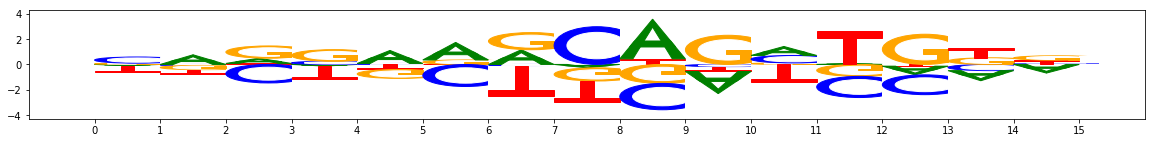

In [8]:
%matplotlib inline
from modisco.visualization import viz_sequence
viz_sequence.plot_weights(TAL1_hocomoco_pwm-np.mean(TAL1_hocomoco_pwm,axis=-1)[:,None])

In [9]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def fast_pwm_scan(array, pwm):
    strided_arr = rolling_window(array.transpose((0,2,1)), window=len(pwm)).transpose((0,2,3,1))
    pwm_scores = np.sum(strided_arr*pwm[None,None,:,:],axis=(2,3))
    return pwm_scores

def sliding_importance_sum(array, window):
    per_position_imp = np.sum(array, axis=-1)
    return np.sum(rolling_window(a=per_position_imp, window=window),axis=-1)

tal_pwm_scores = fast_pwm_scan(array=sequence_onehot, pwm=TAL1_hocomoco_pwm)
importance_in_windows = sliding_importance_sum(array=imp_scores, window=len(TAL1_hocomoco_pwm))

In [18]:
from collections import OrderedDict
important_windows = OrderedDict()
sorted_tal_hits = OrderedDict()
for thresh in [3,0]:
    important_windows[thresh] = np.nonzero(importance_in_windows > thresh)
    sorted_tal_hits[thresh] = sorted(zip(importance_in_windows[
                                          important_windows[thresh][0], important_windows[thresh][1]], 
                                         tal_pwm_scores[important_windows[thresh][0], important_windows[thresh][1]],
                                         important_windows[thresh][0],
                                         important_windows[thresh][1]),
                                         key=lambda x: -x[1])

Plotting top TAL hits where total importance at the motif exceeds 3


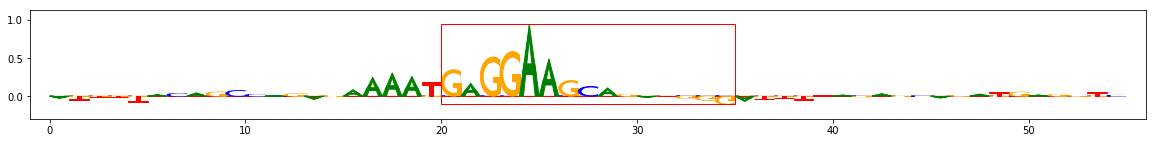

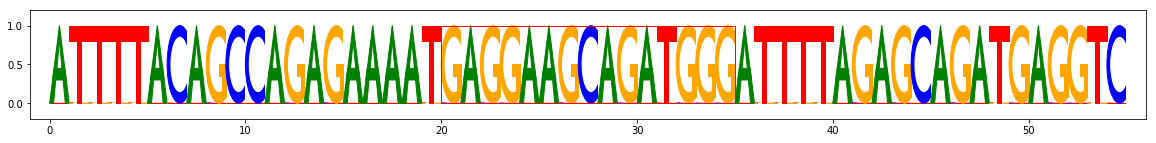

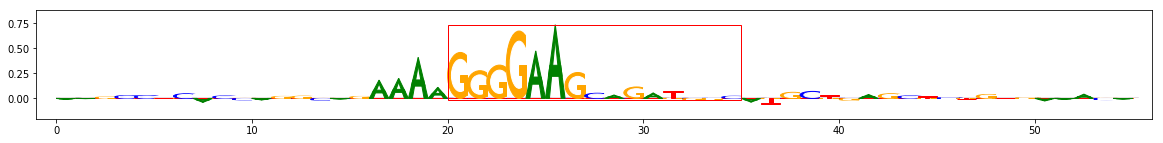

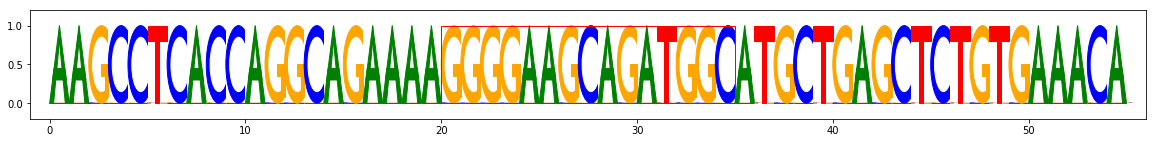

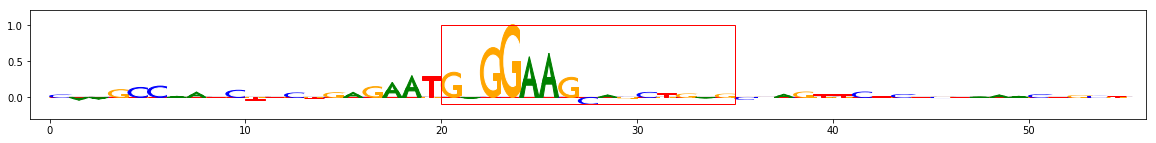

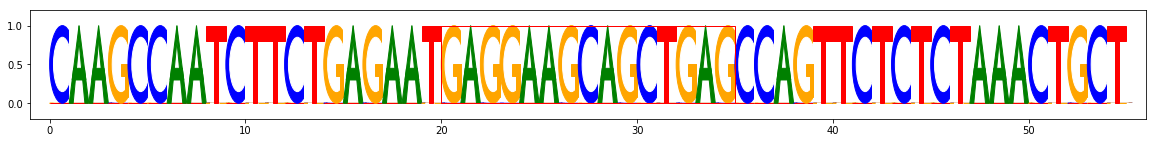

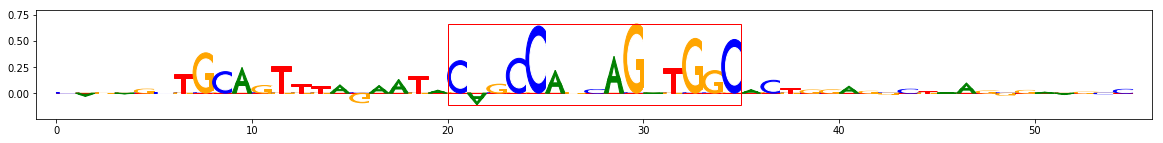

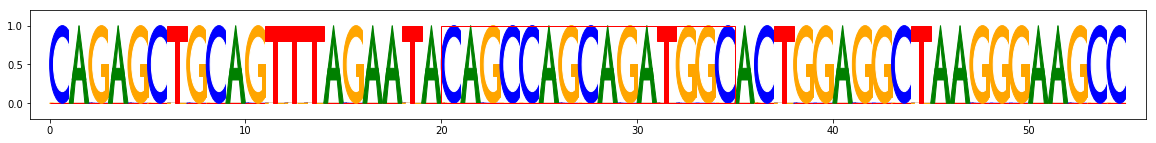

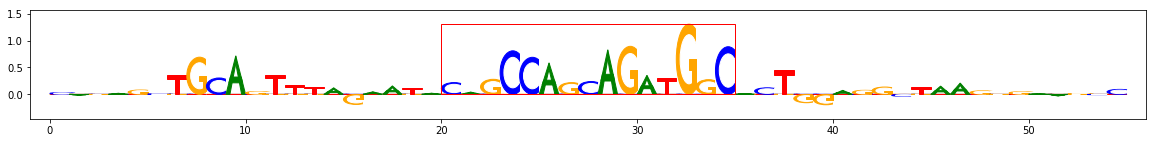

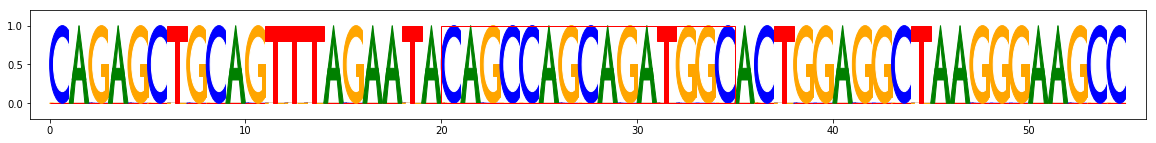

Plotting top TAL hits where total importance at the motif exceeds 0


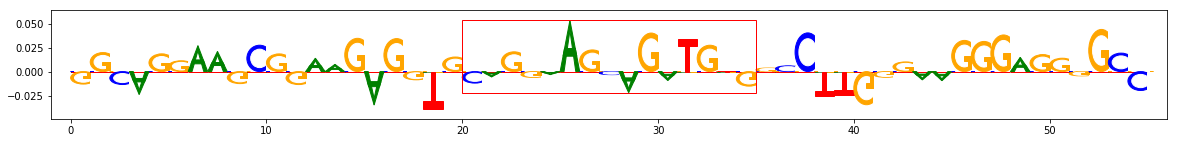

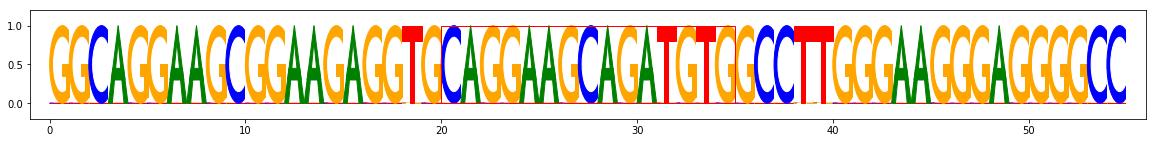

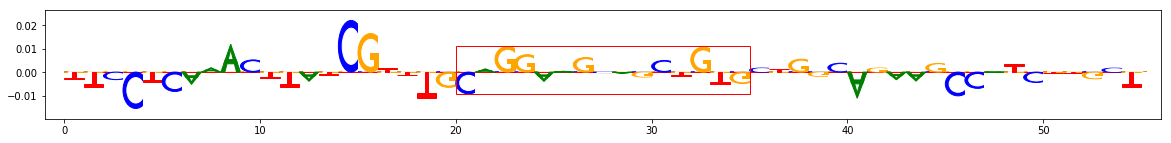

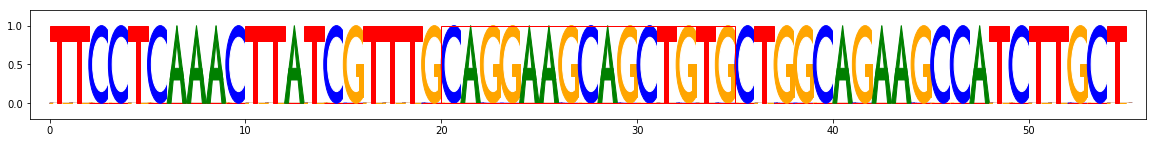

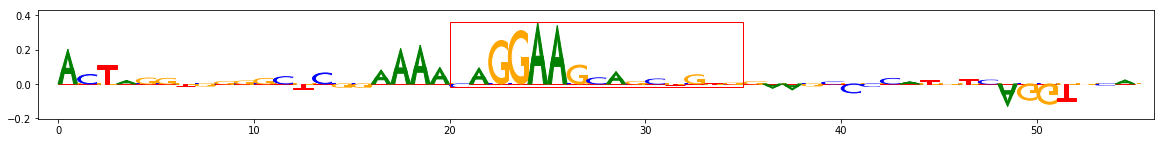

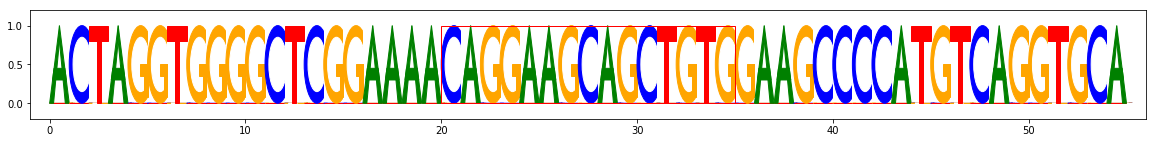

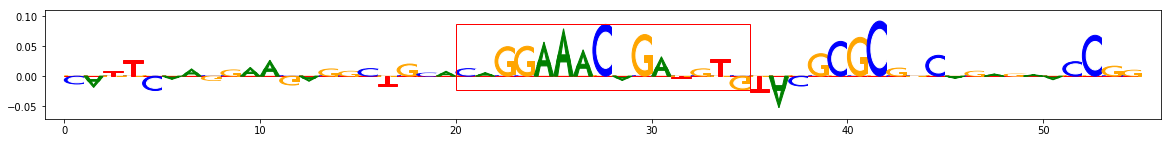

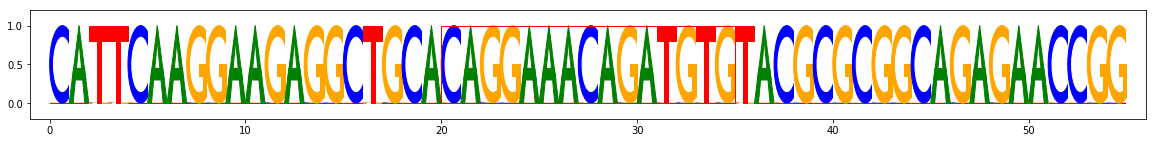

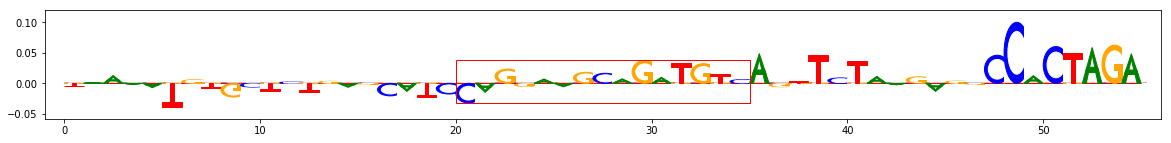

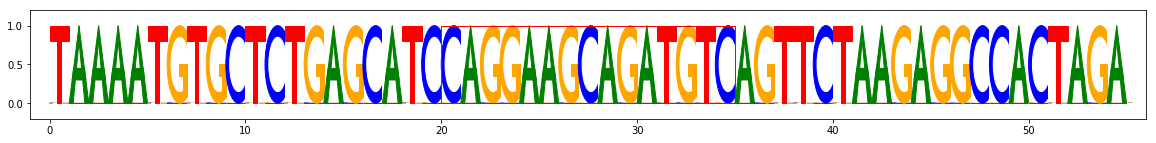

In [19]:
for thresh in important_windows:
    print("Plotting top TAL hits where total importance at the motif exceeds",thresh)
    for idx in range(5):
        viz_sequence.plot_weights(imp_scores[sorted_tal_hits[thresh][idx][2],
                                             sorted_tal_hits[thresh][idx][3]-20:
                                             sorted_tal_hits[thresh][idx][3]+(20+len(TAL1_hocomoco_pwm))],
                                  subticks_frequency=10,
                                  highlight={'red':[(20,20+len(TAL1_hocomoco_pwm))]})
        viz_sequence.plot_weights(sequence_onehot[sorted_tal_hits[thresh][idx][2],
                                             sorted_tal_hits[thresh][idx][3]-20:
                                             sorted_tal_hits[thresh][idx][3]+(20+len(TAL1_hocomoco_pwm))],
                                  subticks_frequency=10,
                                  highlight={'red':[(20,20+len(TAL1_hocomoco_pwm))]})

In [12]:
import modisco
modisco_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/Naive_modisco2019/task_273-naivegw/results.hdf5"
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["task"],
                contrib_scores={"task": imp_scores},
                hypothetical_contribs={"task": hyp_scores},
                one_hot=sequence_onehot)
grp = h5py.File(modisco_file,"r")
loaded_tfmodisco_results =\
    modisco.tfmodisco_workflow.workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

metacluster_0
0
num seqlets 1948


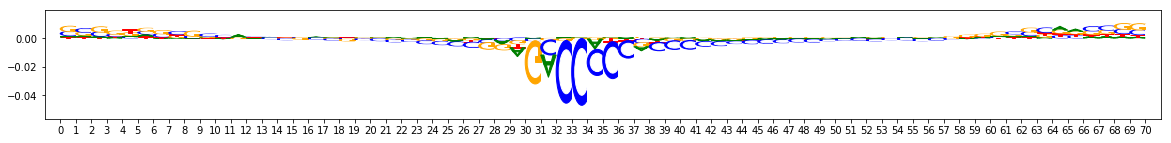

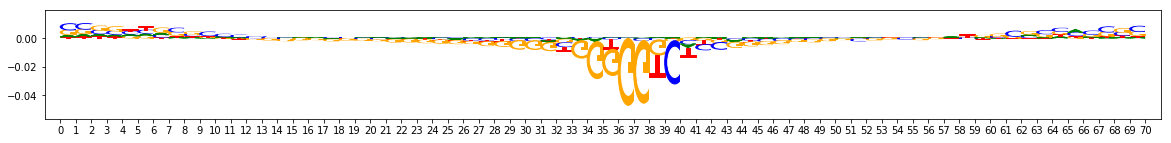

1
num seqlets 1822


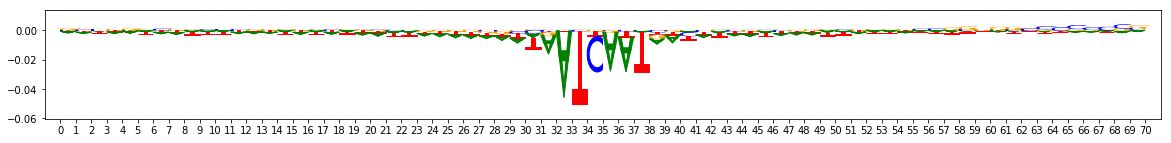

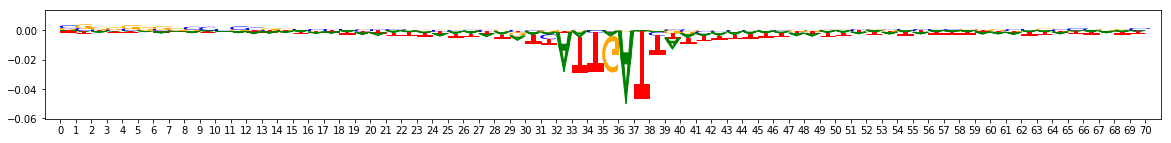

2
num seqlets 1598


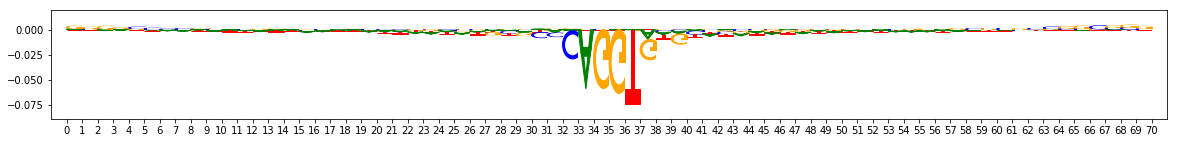

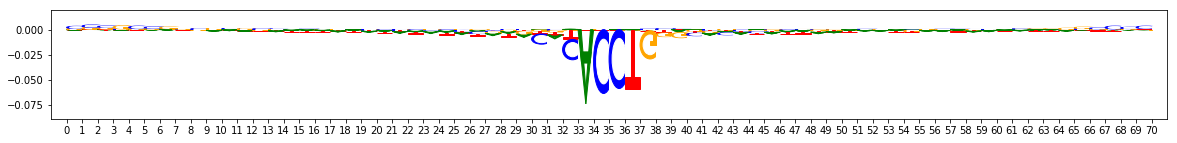

3
num seqlets 873


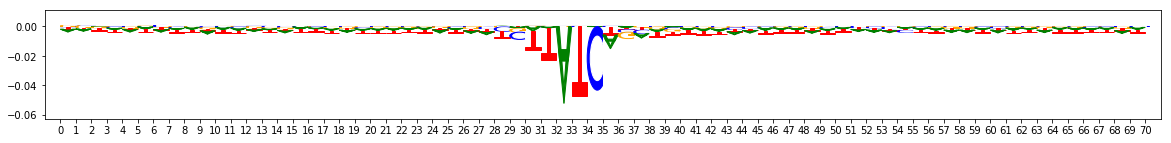

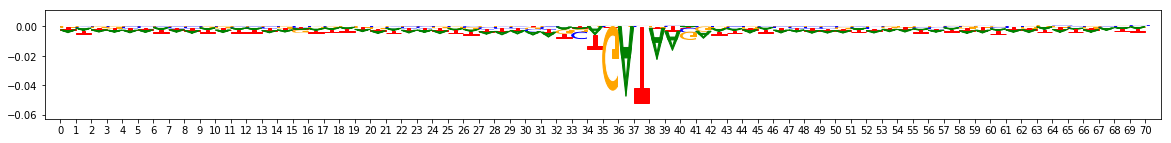

4
num seqlets 763


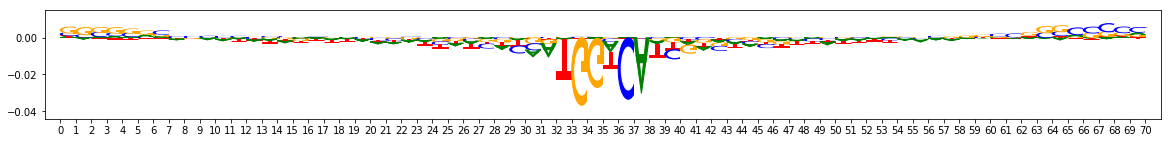

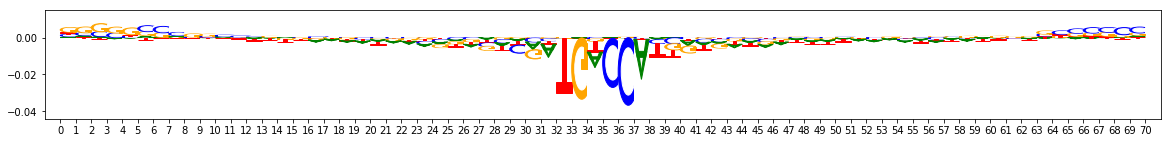

5
num seqlets 499


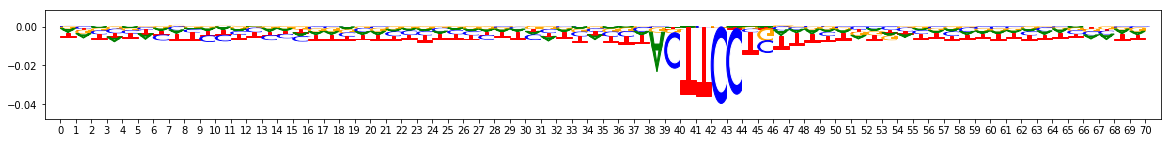

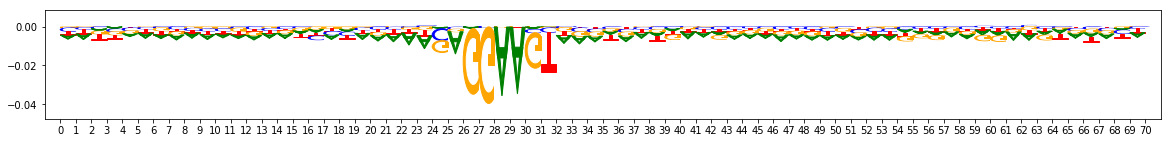

6
num seqlets 352


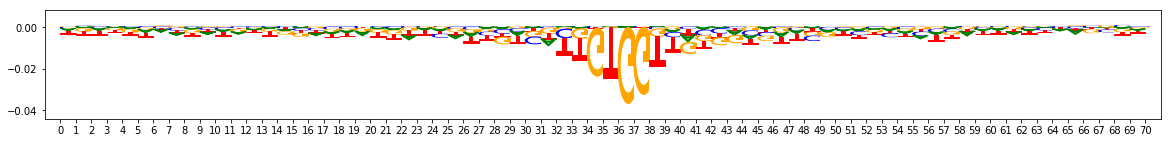

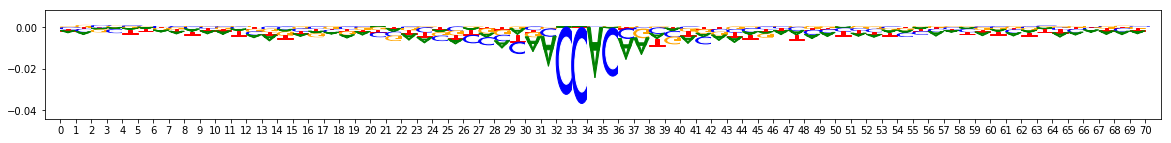

7
num seqlets 357


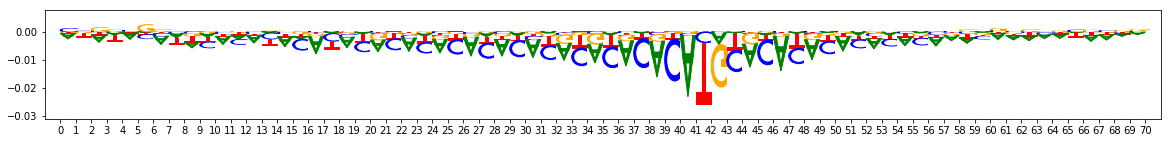

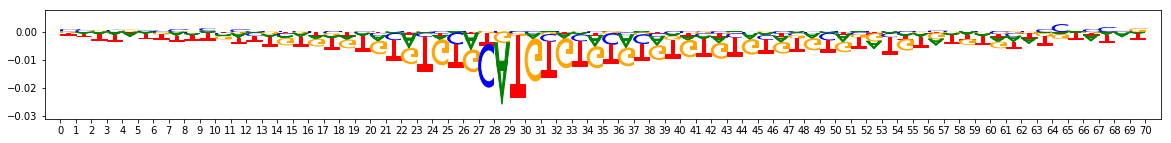

8
num seqlets 322


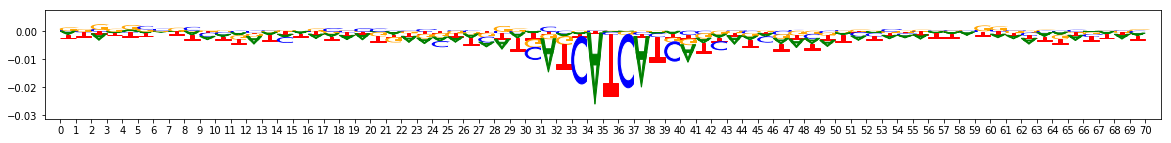

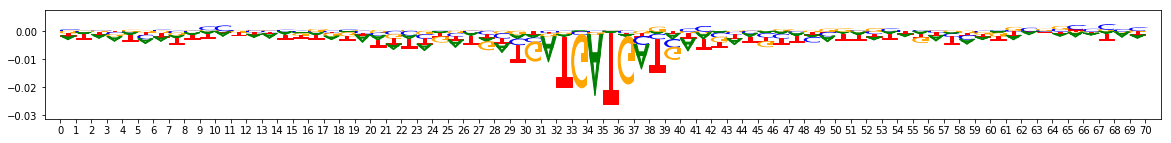

9
num seqlets 267


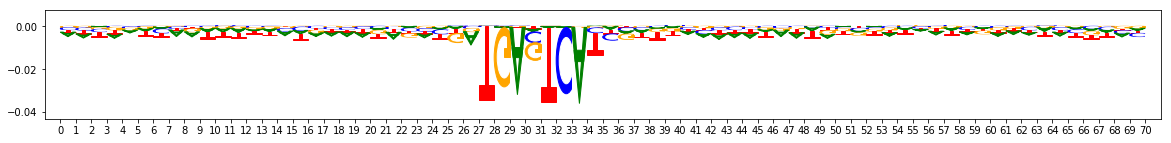

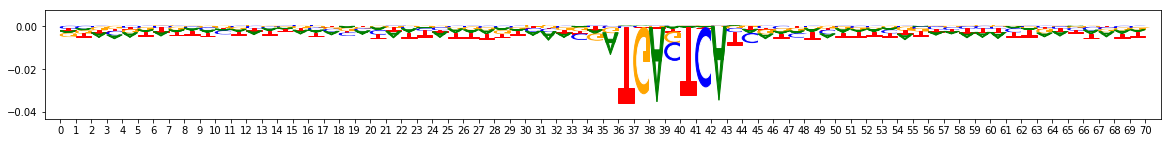

10
num seqlets 196


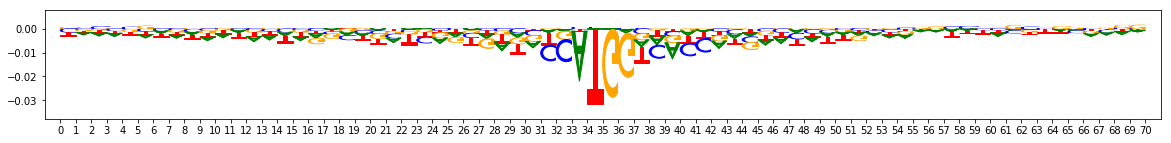

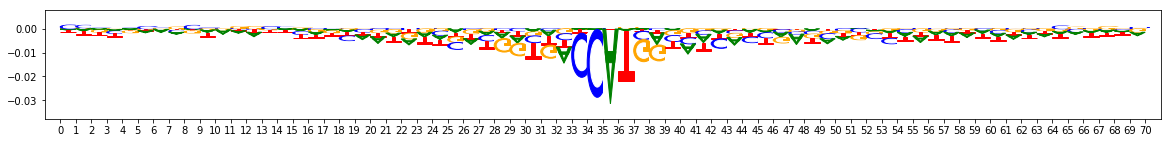

11
num seqlets 176


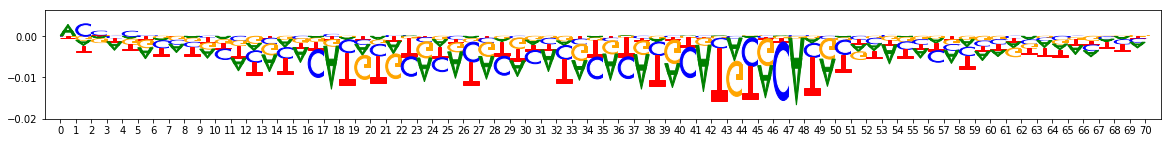

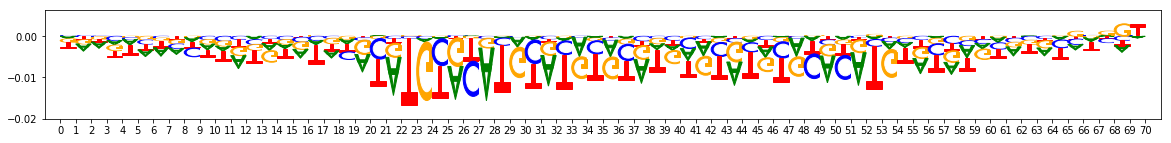

12
num seqlets 108


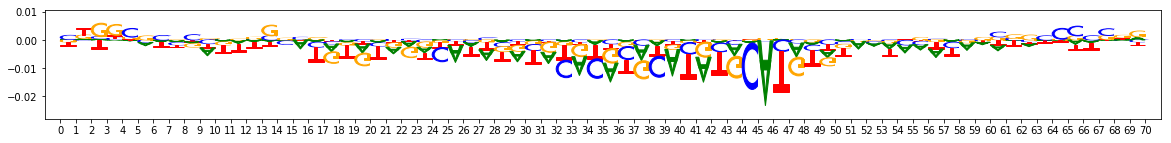

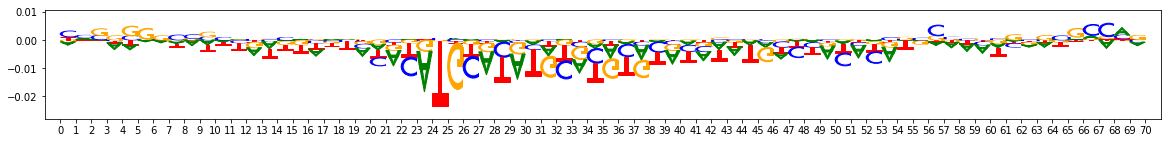

13
num seqlets 109


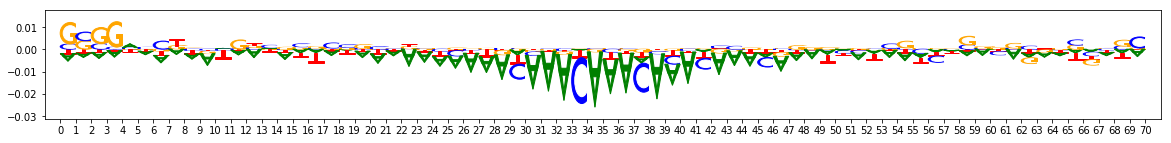

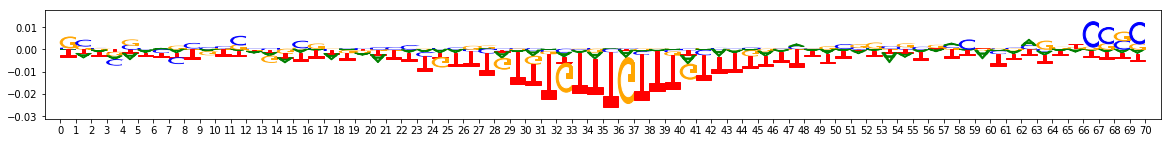

14
num seqlets 92


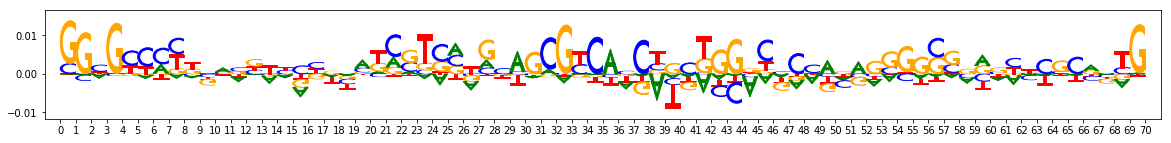

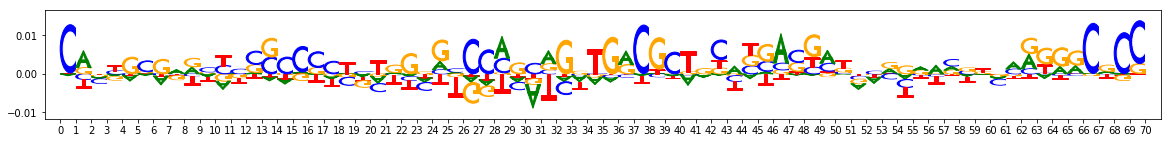

15
num seqlets 92


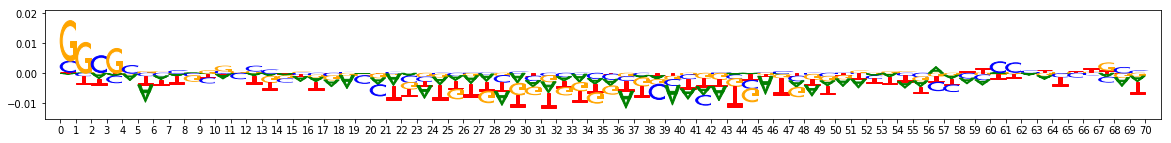

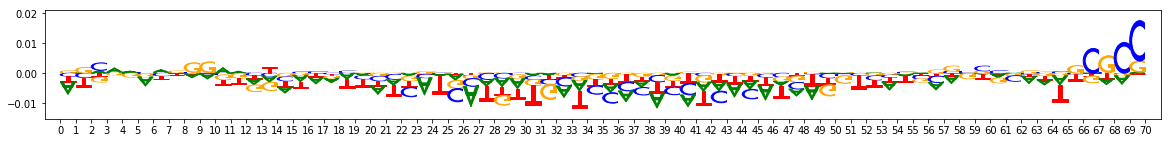

16
num seqlets 83


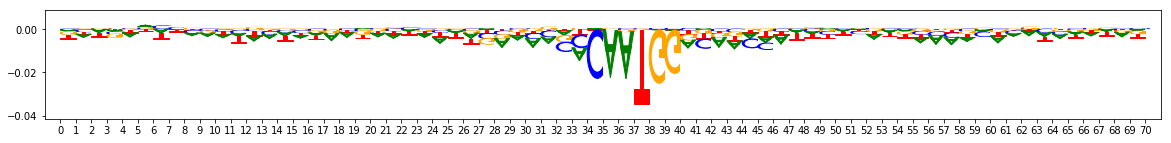

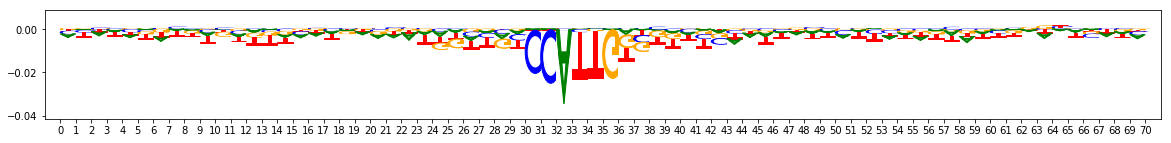

17
num seqlets 91


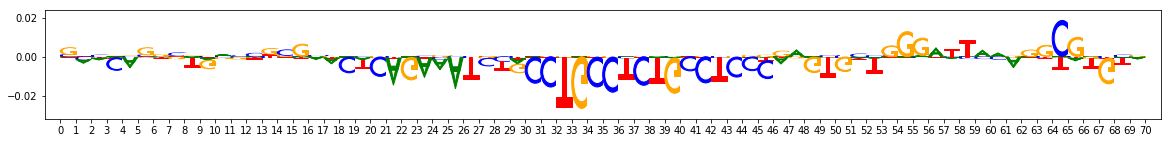

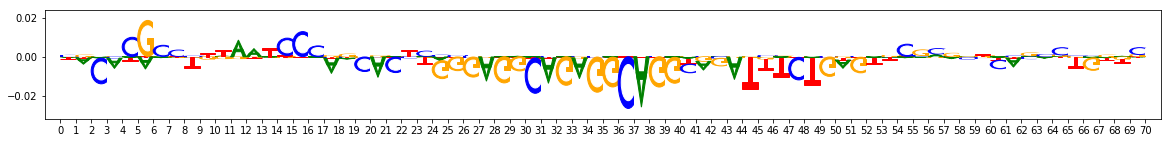

18
num seqlets 76


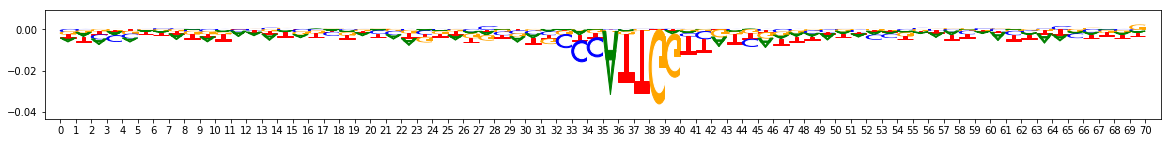

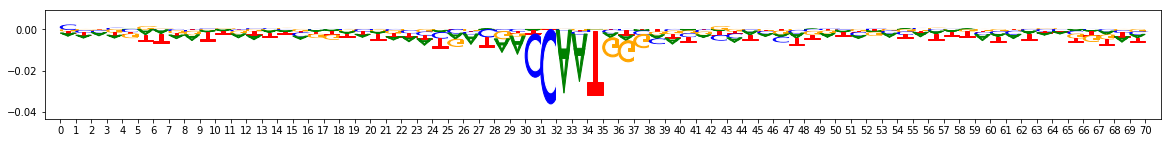

19
num seqlets 45


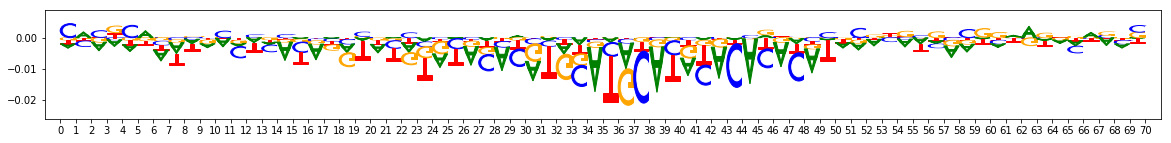

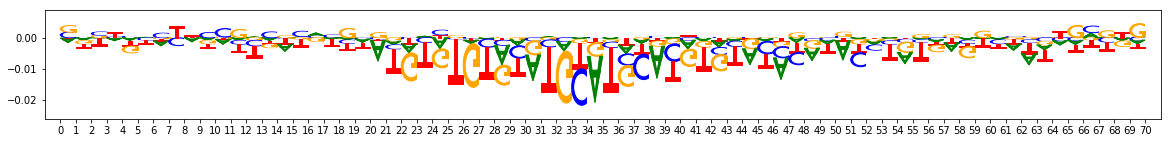

20
num seqlets 49


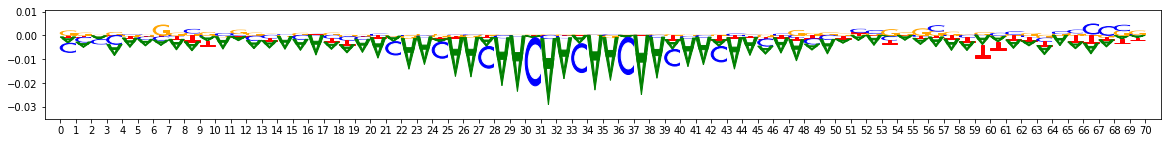

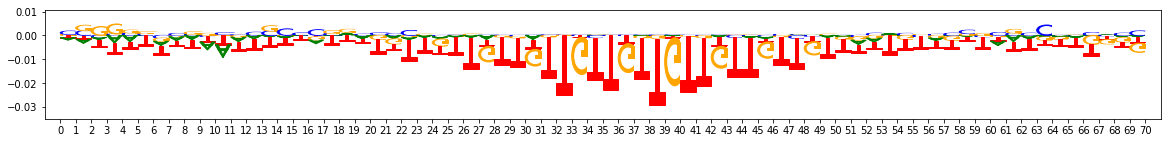

21
num seqlets 36


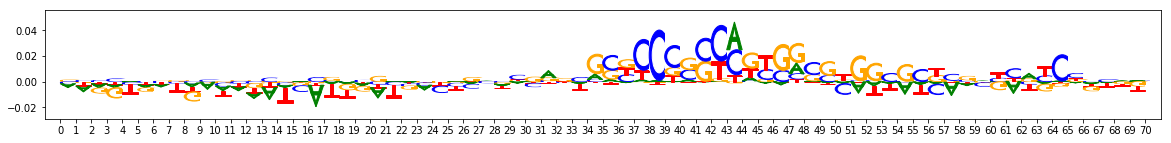

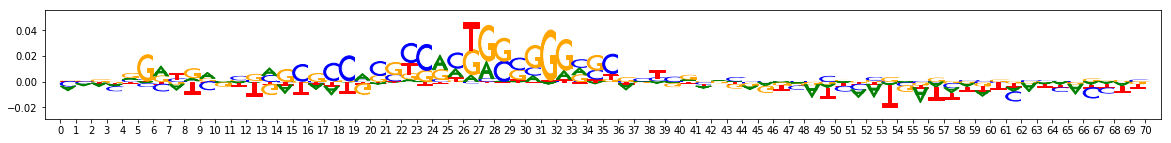

metacluster_1
0
num seqlets 7675


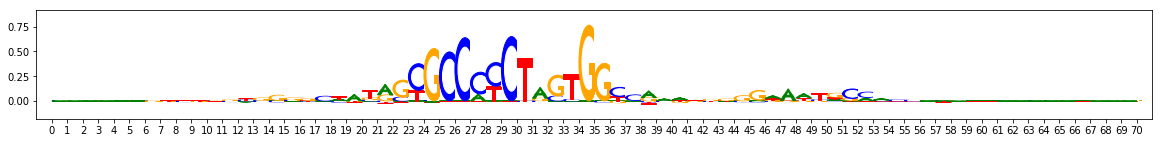

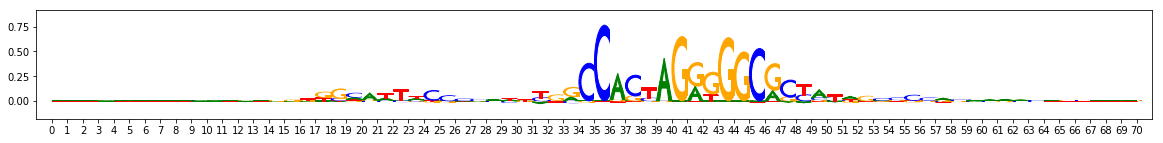

1
num seqlets 6372


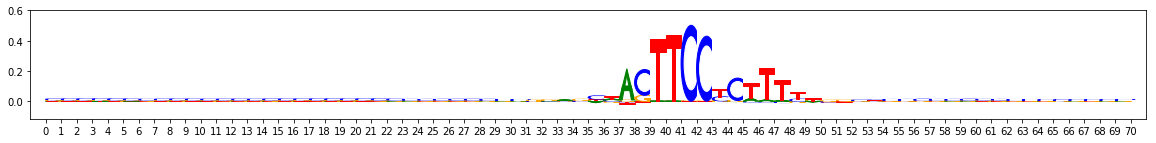

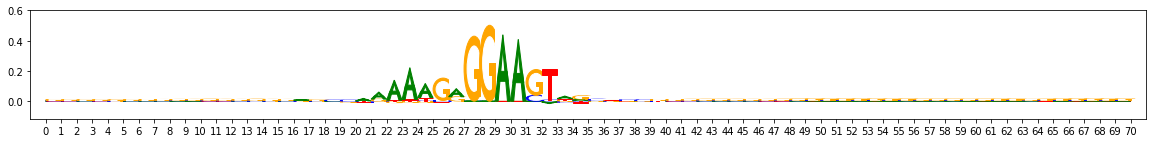

2
num seqlets 2645


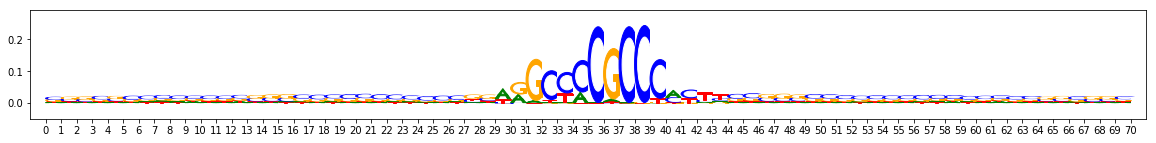

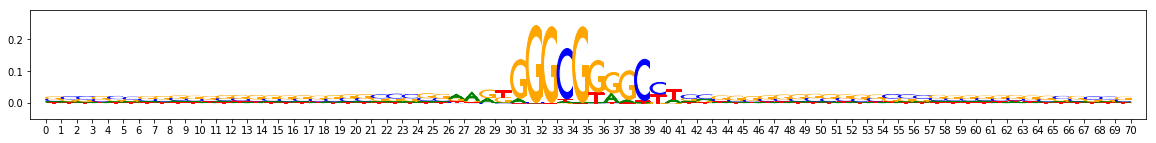

3
num seqlets 1077


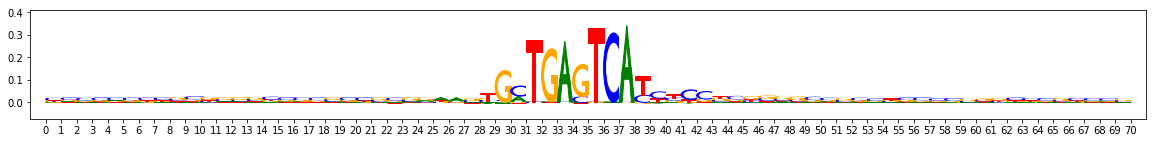

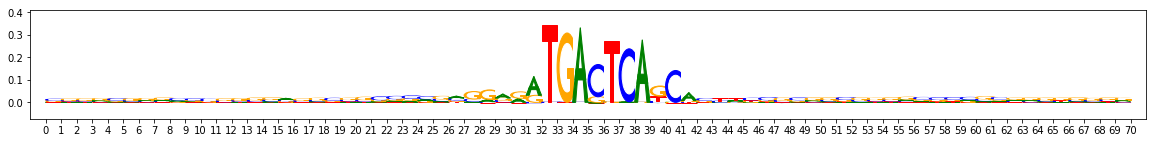

4
num seqlets 988


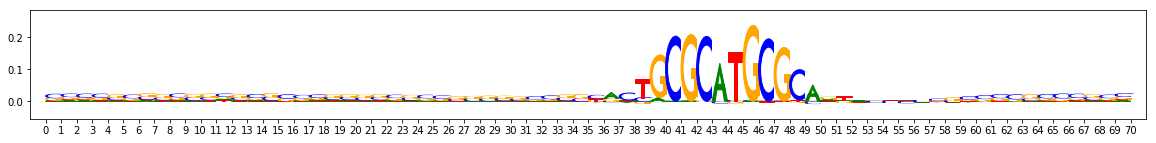

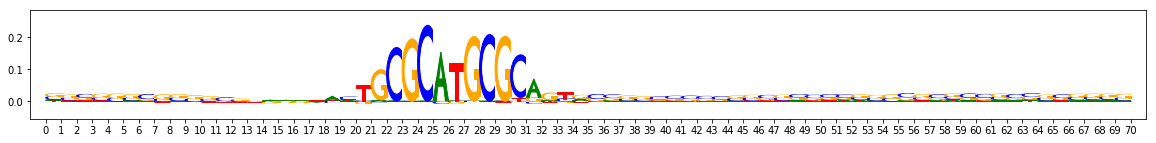

5
num seqlets 986


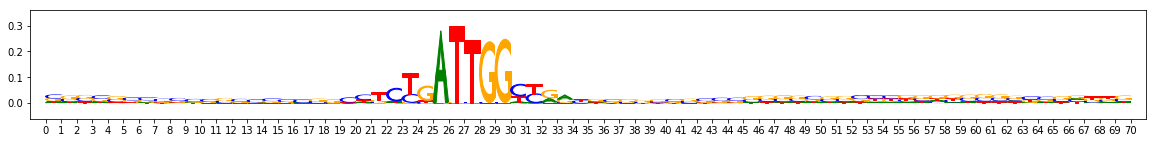

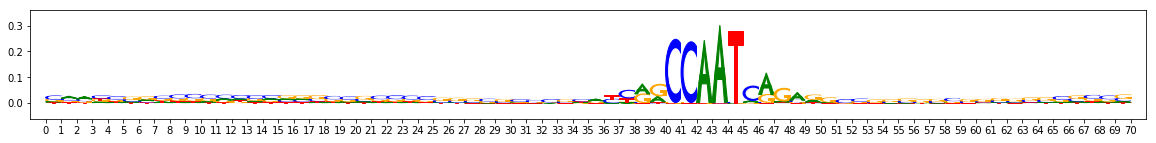

6
num seqlets 981


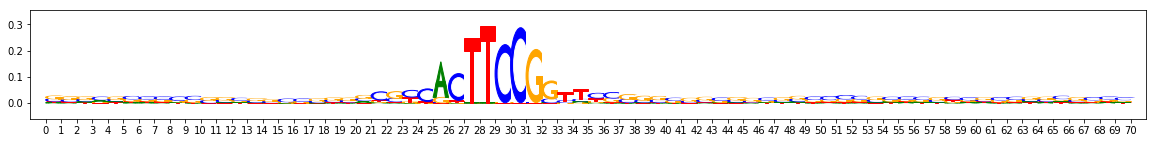

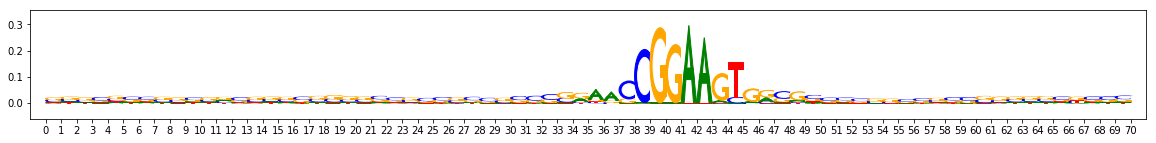

7
num seqlets 883


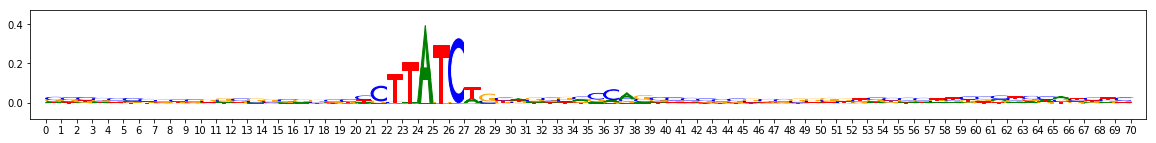

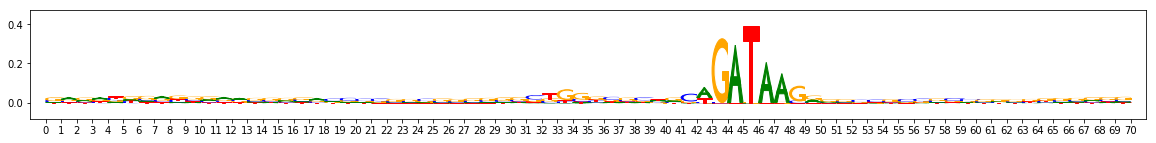

8
num seqlets 605


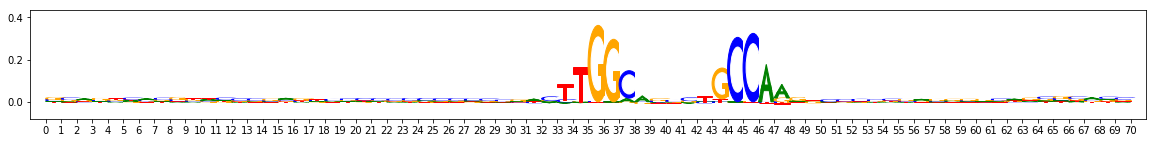

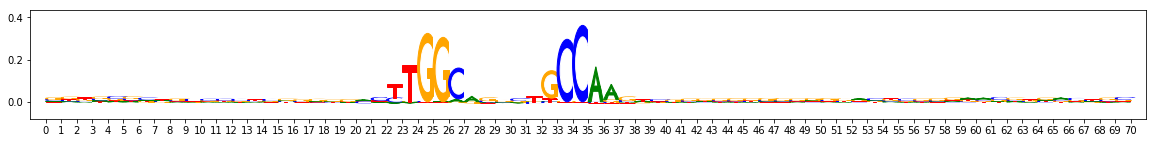

9
num seqlets 556


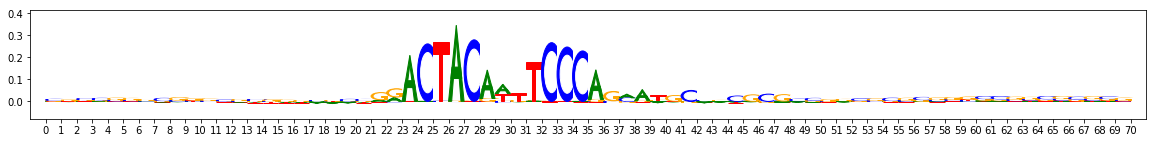

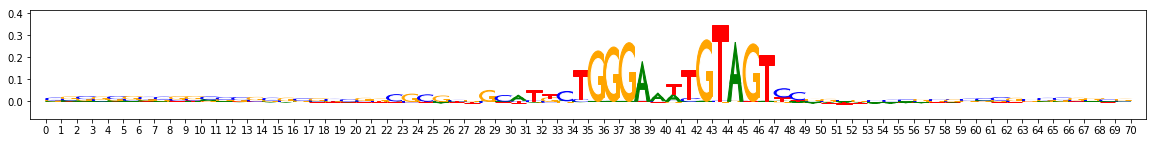

10
num seqlets 404


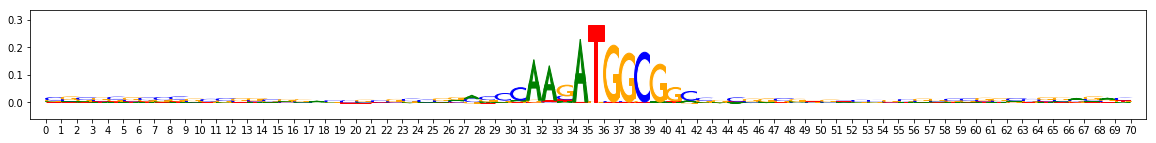

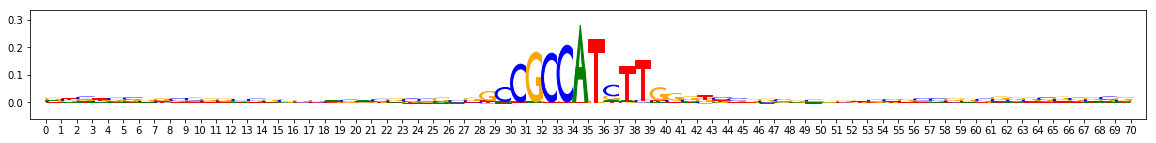

11
num seqlets 368


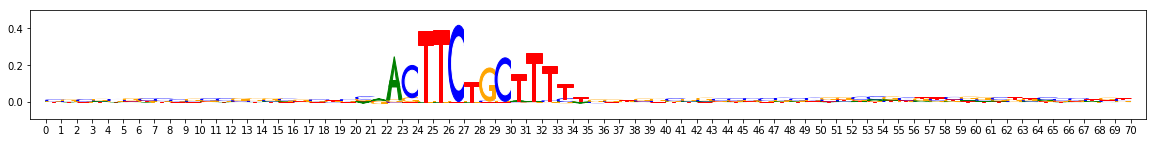

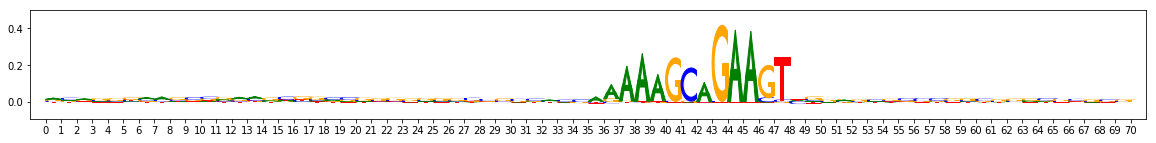

12
num seqlets 341


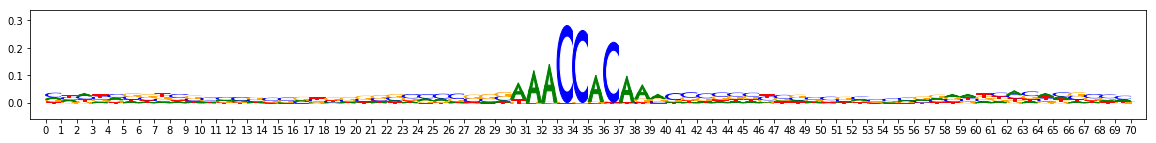

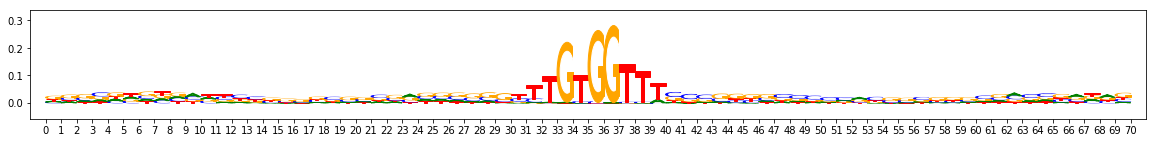

13
num seqlets 239


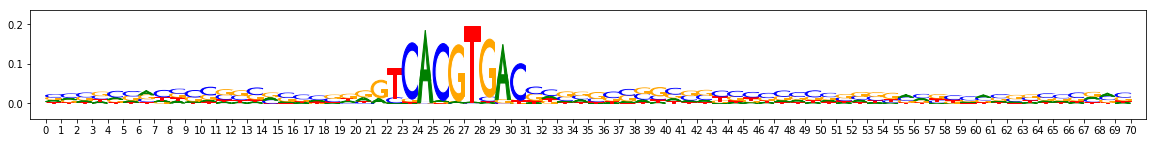

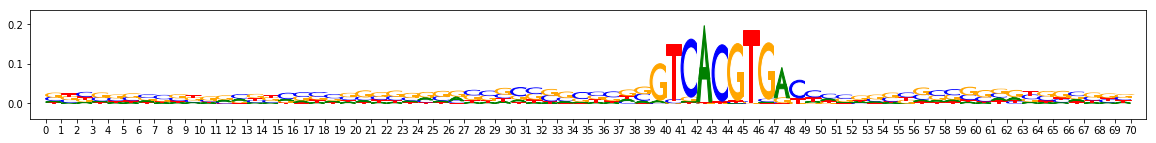

14
num seqlets 228


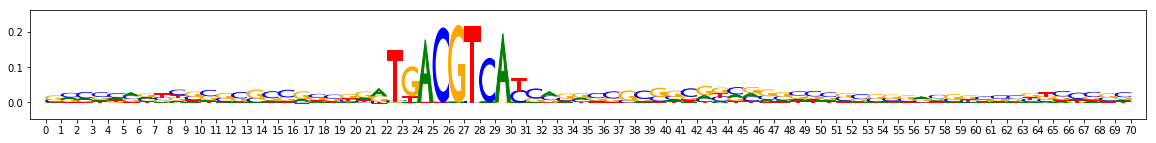

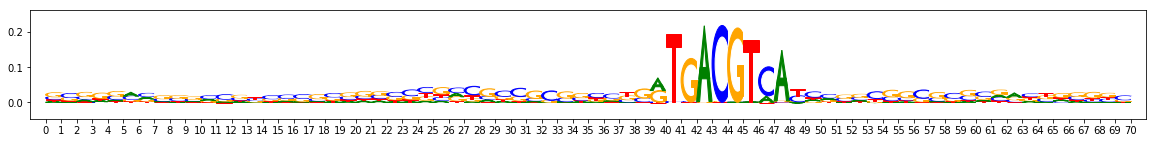

15
num seqlets 189


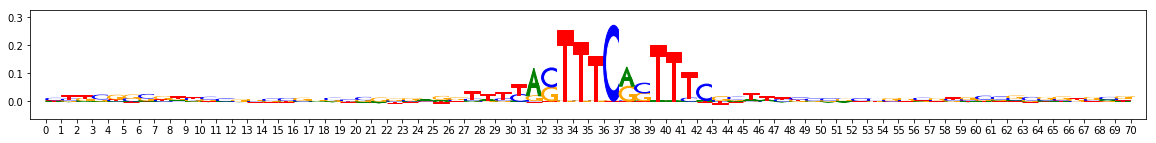

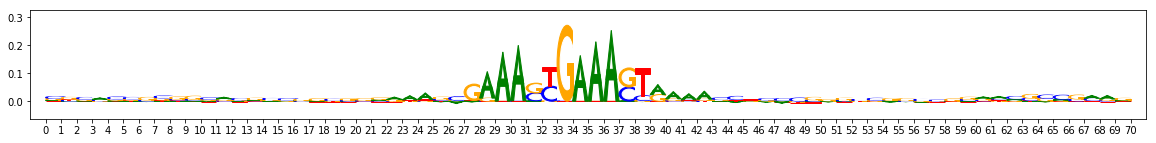

16
num seqlets 168


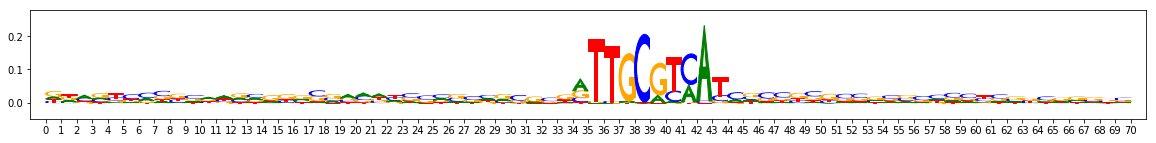

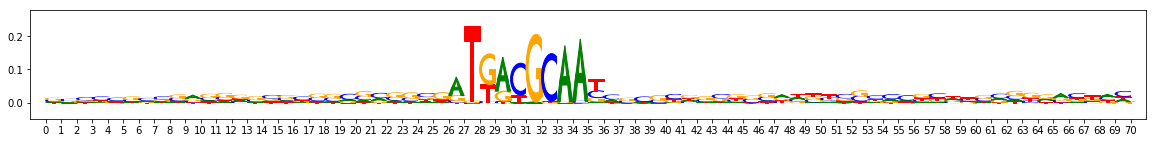

17
num seqlets 117


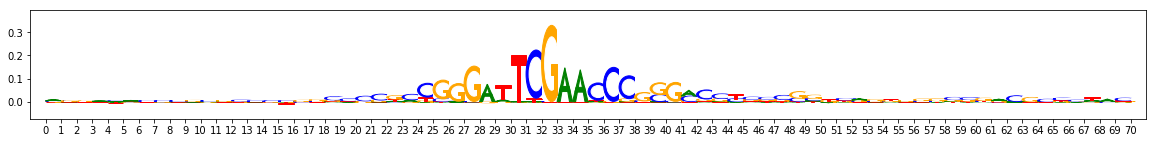

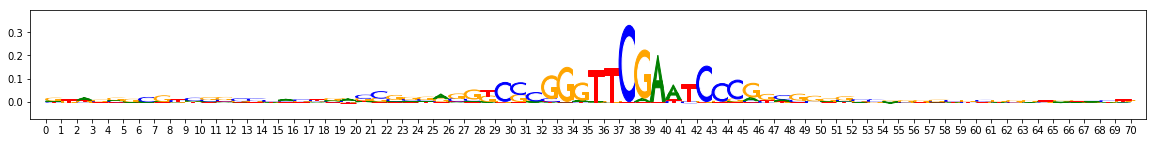

18
num seqlets 64


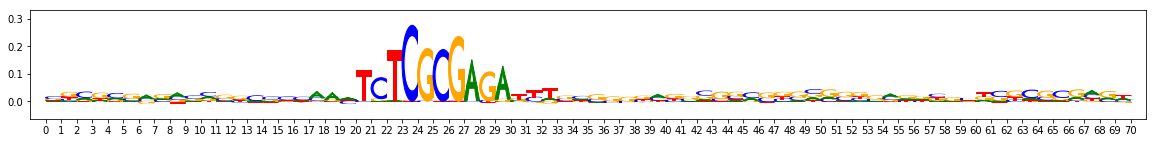

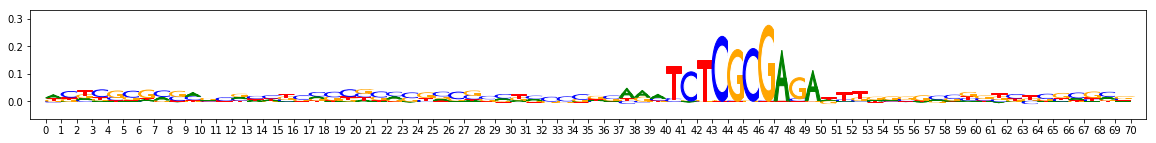

19
num seqlets 51


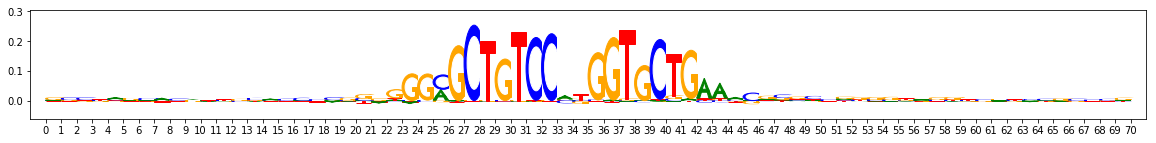

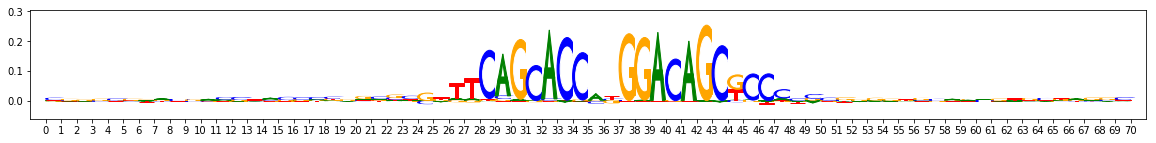

In [13]:
from modisco.visualization import viz_sequence

for metacluster_name in loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results:
    print(metacluster_name)
    metacluster_patterns = (
        loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results[metacluster_name]
                                .seqlets_to_patterns_result
                                .patterns)
    for pattern_idx,pattern in enumerate(metacluster_patterns):
        print(pattern_idx)
        print("num seqlets", len(pattern.seqlets))
        viz_sequence.plot_weights(pattern["task_contrib_scores"].fwd)
        viz_sequence.plot_weights(pattern["task_contrib_scores"].rev)
    
